<a href="https://colab.research.google.com/github/bruckman/KISD_Statistics_ex-1/blob/master/LS_fit_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections as collections
from scipy import stats
from scipy import special
from scipy import integrate
from scipy import optimize

#  Template for the LS fit to data

In [24]:
def gauss(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def decay(x, tau):
    return np.exp(-x/tau) / tau

In [27]:
def chi2(mus, hist, bins, xmin=0, xmax=30.0, tau0=5.0, mu0=10.0, sigma0=3.0):
    chi2_val = 0.0
    n_bins = len(hist)
    
    for i in range(n_bins):
        a = bins[i]
        b = bins[i+1]
        
# Integrate normalized signal PDF over [a, b]
        s_int, _ = integrate.quad(lambda x: gauss(x, mu0, sigma0) * scales, a, b)
        
# Integrate normalized background PDF over [a, b]
        b_int, _ = integrate.quad(lambda x: decay(x, tau0) * scaleb, a, b)
        expected = mus * s_int + (nhist - mus) * b_int
        observed = hist[i]
        
# Avoid division by zero
        if expected <= 0:
            expected = 1e-6  
        chi2_val += (observed - expected)**2 / expected
    return chi2_val

In [28]:
# Define known constants
tau = 5.0
mu = 10.0
sigma = 3.0

# Define some auxiliary parameters 
plow = 0.0
phig = 40.0
ndistr = 1000

# Deafine the histogram
nbins=10
xrange = 30

x = np.linspace(0, xrange, ndistr)

# Load the raw data from file:
rndy = np.load("raw_data_3_tau5.npy")
nhist = len(rndy)

In [ ]:
# Find the p.d.f. normalisation factors for the considered interval (0, xrange) 
integrals = integrate.quad(gauss, 0, xrange, args=(mu, sigma))
print('integrals = ', integrals[0])
scales = 1/integrals[0]
integralb = integrate.quad(decay, 0, xrange, args=(tau,))
print('integralb = ', integralb[0])
scaleb = 1/integralb[0]

# Histogram the raw data
hy, binsy = np.histogram(rndy, bins=nbins, range=(0.0, xrange) )

integrals =  0.9995709396537192
integralb =  0.9975212478233337


In [31]:
# Find the extremum of either logL or chi2
in_guess = [0,]
minimum = optimize.minimize(chi2, in_guess, args=(hy, binsy ,0.0, xrange, tau, mu, sigma))
fitted_mus = minimum.x[0]
print('extremum found for mus = ',fitted_mus)

extremum found for mus =  17.11409591605853


In [32]:
# Set dummy uncertainties
sigma_neg = fitted_mus-10
sigma_pos = fitted_mus+10
#  Estimate the error:
pl = np.linspace(plow, phig, ndistr)
ll_array = []
for xx in pl:
   ll_array.append(chi2(xx, hy, binsy, 0.0, xrange, tau, mu, sigma))

# Estimate the error:
chi2_min = minimum.fun
chi2_target = chi2_min + 1

# Find indices where ll_array crosses chi2_target
below_target = np.where(np.array(ll_array) <= chi2_target)[0]

if len(below_target) == 0:
    sigma_neg, sigma_pos = 0, 0
else:
# Left bound (sigma_neg)
    left_idx = below_target[0]
    if left_idx > 0:
        x0, y0 = pl[left_idx - 1], ll_array[left_idx - 1] - chi2_target
        x1, y1 = pl[left_idx], ll_array[left_idx] - chi2_target
        t = -y0 / (y1 - y0)
        left_bound = x0 + t * (x1 - x0)
    else:
        left_bound = pl[left_idx]
    
# Right bound (sigma_pos)
    right_idx = below_target[-1]
    if right_idx < len(pl) - 1:
        x0, y0 = pl[right_idx], ll_array[right_idx] - chi2_target
        x1, y1 = pl[right_idx + 1], ll_array[right_idx + 1] - chi2_target
        t = -y0 / (y1 - y0)
        right_bound = x0 + t * (x1 - x0)
    else:
        right_bound = pl[right_idx]
    
    sigma_neg = fitted_mus - left_bound
    sigma_pos = right_bound - fitted_mus

print("-sigma = %2.3f,  +sigma = %2.3f"%(sigma_neg, sigma_pos))

-sigma = 7.384,  +sigma = 7.937


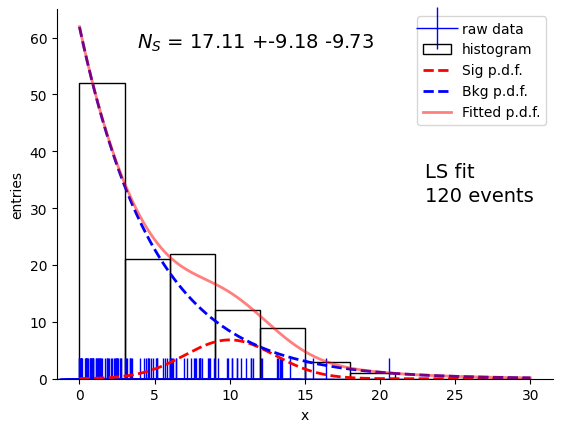

In [33]:
# fitted p.d.f.:
y = (fitted_mus/nhist*scales*gauss(x, mu, sigma)+(nhist-fitted_mus)/nhist*scaleb*decay(x, tau))
ys = (fitted_mus/nhist*scales*gauss(x, mu, sigma))
yb = ((nhist-fitted_mus)/nhist*scaleb*decay(x, tau))

fig, ax = plt.subplots()

ax.plot(rndy, np.zeros(rndy.shape), 'b+', ms=30, label="raw data")  # rug plot
ax.hist(rndy, bins=nbins, range=(0.0, xrange), fill=False, color='green', label="histogram")  # histogram

ax.plot(x, nhist*xrange*(1/nbins)*ys, 'r', linewidth=2, linestyle='--', label="Sig p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*yb, 'b', linewidth=2, linestyle='--', label="Bkg p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*y, 'r', alpha=0.5, linewidth=2, linestyle='-', label="Fitted p.d.f.")
#ax.set_ylim(bottom=0)

fig.text(0.70, 0.53, 'LS fit', fontsize=14)
fig.text(0.70, 0.48, '%d events'%nhist, fontsize=14)
fig.text(0.25, 0.80, '$N_S$ = %2.2f +%2.2f -%2.2f'%(fitted_mus,sigma_pos-fitted_mus,fitted_mus-sigma_neg), fontsize=14)
#fig.text(0.25, 0.80, '$N_S$ = %2.2f'%(fitted_mus), fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.legend(loc=1, fontsize=10)

ax.set_xlabel('x')
ax.set_ylabel('entries')

plt.show()